## Testing
Testing Heff 2, with decreasing Rk4 step size to see if that reduces the residual signal outside the light cone

Shape: (200, 15)
[2.58289536e-01 8.34337404e-01 1.29246961e-01 5.84669256e-01
 3.41108211e-01 3.52643247e-01 2.38400047e-01 8.10780907e-02
 1.58712325e-02 1.99595053e-03 1.57277041e-04 1.07303938e-05
 2.20137764e-05 2.25959620e-05 2.26197228e-05]


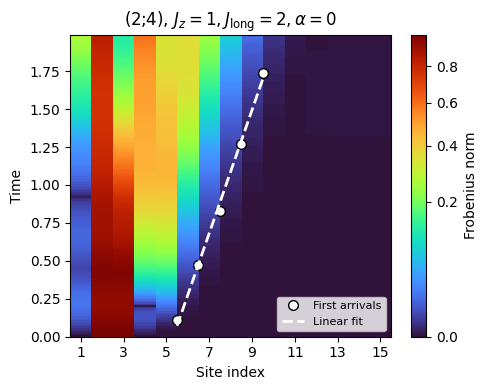

C:\Users\shrey\AppData\Local\Temp\ipykernel_20804\2057454329.py:156: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(log_model, x_fit_points, logy,


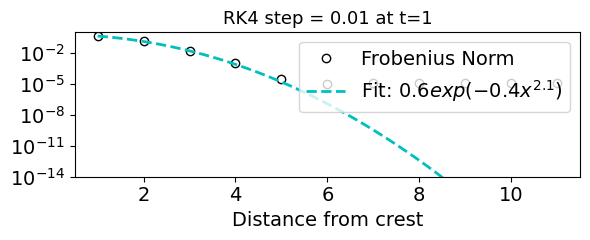

profile [4.34983635e-01 1.29493252e-01 1.59520203e-02 1.03637360e-03
 3.09732860e-05 1.03171434e-05 1.14594924e-05 1.14822478e-05
 1.14825900e-05 1.14825940e-05 1.14825940e-05]


In [29]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    Returns: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces
            line = line.strip().lstrip("{").rstrip("}")
            
            # Split by comma
            entries = line.split(",")
            
            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                # Remove the "+ 0.*I" if present
                e = e.split("+")[0].strip()
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
# data_path = r"D:\OneDrive - Tulane University\RESEARCH\Quantum transport\Code\Plots\B0LFIMwithLR\N15B0LFIMHeffb2lcalpha05test\N15B0LFIMHeffJlong2b1lc.txt"

data_path = os.path.join("src", "RK10_2.txt")

# Load data from file; first column = time, rest = spatial density over time
raw_data = load_mathematica_data(data_path)


print("Shape:", raw_data.shape)
print(raw_data[-3])  # print first two rows


# Example: dummy first arrival points
# === First arrival points (site, time) ===
arrivals = [
    (5, 0.11),
    (6, 0.47),
    (7, 0.83),
    (8, 1.27),
    (9, 1.74),
]




x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params

# === Simulation step size ===
step_size = 0.01   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max+0.001]  # <-- keep full extent
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'w--', linewidth=2, label="Linear fit")

# Labels
plt.colorbar(im, label="Frobenius norm")
plt.xlabel("Site index")
plt.ylabel("Time")
plt.title(r"(2;4), $J_z=1, J_{\mathrm{long}}=2, \alpha=0$")

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)

plt.xticks(positions, labels)


plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
# plt.savefig("plt/N15B0LFIMHeffJlong2b1lc.svg", bbox_inches="tight") 
plt.show()

import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 4:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 3   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(6, 2.5))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Frobenius Norm")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=14)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"RK4 step = {step_size} at t={time}", fontsize=13)
plt.ylim(1e-14, 1)   # y-axis range
plt.legend(fontsize=14, loc="upper right")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
# plt.savefig("plt/N15B0LFIMHeffJlong2b1lc_profile.svg", bbox_inches="tight")
plt.show()

print("profile",profile)

Shape: (2000, 15)
[2.63512045e-01 8.41313215e-01 1.31057583e-01 5.94269965e-01
 3.40218403e-01 3.51842608e-01 2.43943279e-01 8.53684887e-02
 1.71833695e-02 2.23837494e-03 2.04431764e-04 1.38389182e-05
 7.22860216e-07 2.97606162e-08 8.03601630e-10]


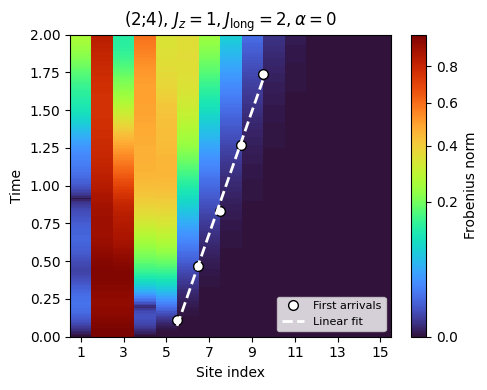

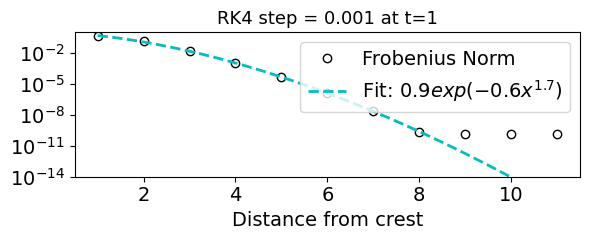

profile [4.37252024e-01 1.29953075e-01 1.60323824e-02 1.05460952e-03
 4.28467754e-05 1.17963921e-06 2.33230102e-08 2.17004192e-10
 1.31605837e-10 1.35780276e-10 1.35802480e-10]


In [27]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    Returns: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces
            line = line.strip().lstrip("{").rstrip("}")
            
            # Split by comma
            entries = line.split(",")
            
            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                # Remove the "+ 0.*I" if present
                e = e.split("+")[0].strip()
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
# data_path = r"D:\OneDrive - Tulane University\RESEARCH\Quantum transport\Code\Plots\B0LFIMwithLR\N15B0LFIMHeffb2lcalpha05test\N15B0LFIMHeffJlong2b1lc.txt"

data_path = os.path.join("src", "RK10_3.txt")

# Load data from file; first column = time, rest = spatial density over time
raw_data = load_mathematica_data(data_path)


print("Shape:", raw_data.shape)
print(raw_data[-3])  # print first two rows


# Example: dummy first arrival points
# === First arrival points (site, time) ===
arrivals = [
    (5, 0.11),
    (6, 0.47),
    (7, 0.83),
    (8, 1.27),
    (9, 1.74),
]




x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params

# === Simulation step size ===
step_size = 0.001   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max+0.001]  # <-- keep full extent
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'w--', linewidth=2, label="Linear fit")

# Labels
plt.colorbar(im, label="Frobenius norm")
plt.xlabel("Site index")
plt.ylabel("Time")
plt.title(r"(2;4), $J_z=1, J_{\mathrm{long}}=2, \alpha=0$")

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)

plt.xticks(positions, labels)


plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
# plt.savefig("plt/N15B0LFIMHeffJlong2b1lc.svg", bbox_inches="tight") 
plt.show()

import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 4:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 7   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(6, 2.5))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Frobenius Norm")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=14)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"RK4 step = 0.001 at t={time}", fontsize=13)
plt.ylim(1e-14, 1)   # y-axis range
plt.legend(fontsize=14, loc="upper right")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
# plt.savefig("plt/N15B0LFIMHeffJlong2b1lc_profile.svg", bbox_inches="tight")
plt.show()

print("profile",profile)

Shape: (20000, 15)
[2.60014829e-01 8.46179774e-01 1.37896219e-01 5.95877261e-01
 3.40671221e-01 3.52520400e-01 2.45128966e-01 8.59809001e-02
 1.73543373e-02 2.26750241e-03 2.07771977e-04 1.41150118e-05
 7.40329398e-07 3.08673975e-08 1.10840226e-09]


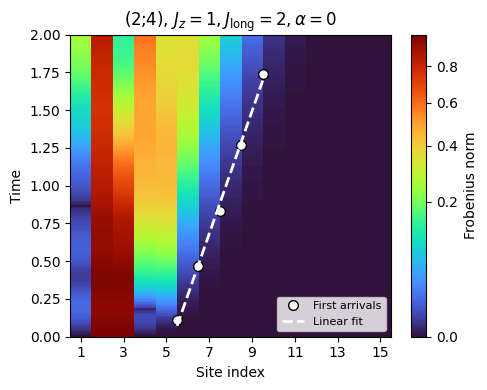

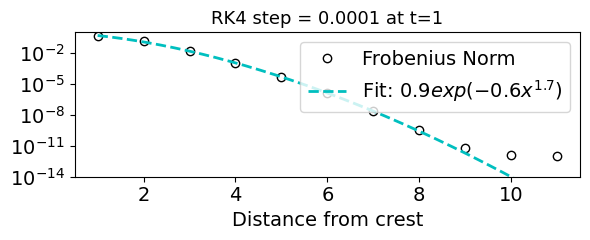

profile [4.38109252e-01 1.31274086e-01 1.62585873e-02 1.07641534e-03
 4.41035978e-05 1.22620281e-06 2.46345833e-08 3.75210973e-10
 5.59552404e-12 1.19904087e-12 1.02140518e-12]


In [15]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    Returns: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces
            line = line.strip().lstrip("{").rstrip("}")
            
            # Split by comma
            entries = line.split(",")
            
            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                # Remove the "+ 0.*I" if present
                e = e.split("+")[0].strip()
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
# data_path = r"D:\OneDrive - Tulane University\RESEARCH\Quantum transport\Code\Plots\B0LFIMwithLR\N15B0LFIMHeffb2lcalpha05test\N15B0LFIMHeffJlong2b1lc.txt"

data_path = os.path.join("src", "RK10_4.txt")

# Load data from file; first column = time, rest = spatial density over time
raw_data = load_mathematica_data(data_path)


print("Shape:", raw_data.shape)
print(raw_data[-3])  # print first two rows


# Example: dummy first arrival points
# === First arrival points (site, time) ===
arrivals = [
    (5, 0.11),
    (6, 0.47),
    (7, 0.83),
    (8, 1.27),
    (9, 1.74),
]




x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params

# === Simulation step size ===
step_size = 0.0001   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max+0.001]  # <-- keep full extent
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'w--', linewidth=2, label="Linear fit")

# Labels
plt.colorbar(im, label="Frobenius norm")
plt.xlabel("Site index")
plt.ylabel("Time")
plt.title(r"(2;4), $J_z=1, J_{\mathrm{long}}=2, \alpha=0$")

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)

plt.xticks(positions, labels)


plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
# plt.savefig("plt/N15B0LFIMHeffJlong2b1lc.svg", bbox_inches="tight") 
plt.show()

import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 4:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 7   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(6, 2.5))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Frobenius Norm")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=14)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"RK4 step = {step_size} at t={time}", fontsize=13)
plt.ylim(1e-14, 1)   # y-axis range
plt.legend(fontsize=14, loc="upper right")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
# plt.savefig("plt/N15B0LFIMHeffJlong2b1lc_profile.svg", bbox_inches="tight")
plt.show()

print("profile",profile)

Shape: (200000, 15)
[2.60014829e-01 8.46179774e-01 1.37896219e-01 5.95877261e-01
 3.40671221e-01 3.52520400e-01 2.45128966e-01 8.59809001e-02
 1.73543373e-02 2.26750241e-03 2.07771985e-04 1.41150198e-05
 7.40337791e-07 3.08754133e-08 1.11639586e-09]


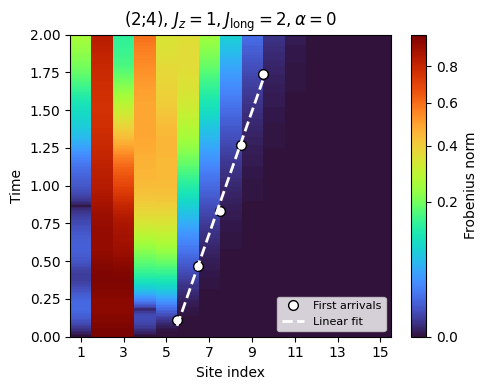

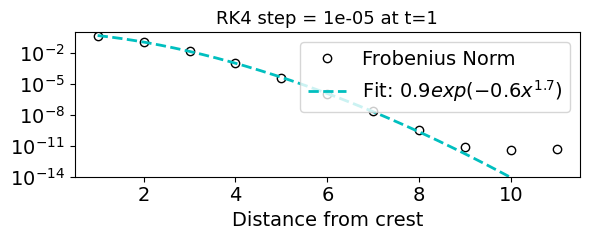

profile [4.36416199e-01 1.27577693e-01 1.54407210e-02 9.99646830e-04
 4.00659056e-05 1.08989120e-06 2.14293916e-08 3.22808447e-10
 8.01581024e-12 4.19664303e-12 4.39648318e-12]


In [16]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    Returns: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces
            line = line.strip().lstrip("{").rstrip("}")
            
            # Split by comma
            entries = line.split(",")
            
            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                # Remove the "+ 0.*I" if present
                e = e.split("+")[0].strip()
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
# data_path = r"D:\OneDrive - Tulane University\RESEARCH\Quantum transport\Code\Plots\B0LFIMwithLR\N15B0LFIMHeffb2lcalpha05test\N15B0LFIMHeffJlong2b1lc.txt"

data_path = os.path.join("src", "RK10_5.txt")

# Load data from file; first column = time, rest = spatial density over time
raw_data = load_mathematica_data(data_path)


print("Shape:", raw_data.shape)
print(raw_data[-3])  # print first two rows


# Example: dummy first arrival points
# === First arrival points (site, time) ===
arrivals = [
    (5, 0.11),
    (6, 0.47),
    (7, 0.83),
    (8, 1.27),
    (9, 1.74),
]




x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params

# === Simulation step size ===
step_size = 0.00001   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max+0.001]  # <-- keep full extent
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'w--', linewidth=2, label="Linear fit")

# Labels
plt.colorbar(im, label="Frobenius norm")
plt.xlabel("Site index")
plt.ylabel("Time")
plt.title(r"(2;4), $J_z=1, J_{\mathrm{long}}=2, \alpha=0$")

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)

plt.xticks(positions, labels)


plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
# plt.savefig("plt/N15B0LFIMHeffJlong2b1lc.svg", bbox_inches="tight") 
plt.show()

import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 4:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 7   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(6, 2.5))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Frobenius Norm")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=14)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"RK4 step = {step_size} at t={time}", fontsize=13)
plt.ylim(1e-14, 1)   # y-axis range
plt.legend(fontsize=14, loc="upper right")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
# plt.savefig("plt/N15B0LFIMHeffJlong2b1lc_profile.svg", bbox_inches="tight")
plt.show()

print("profile",profile)